In [82]:
%matplotlib inline 

###########
#PDF PROCESSING FOR GHCND INPUT 
# DEPENDING ON THE PDF_PROCESSING CLASS
#by Carl Schleussner, Climate Analytics
#carl.schleussner@climateanalytics.org
###########
# IMPORT AND CONFIG 
import numpy as np
import netCDF4 as net
import dimarray as da 
import sys
sys.path.append("./src/")
import itertools
import glob
import datetime
import pickle
import os
import pandas as pd
import matplotlib.pylab as plt 
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 8,6

try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")





In [83]:
###########
# Settings
###########

# Set GMT dataset
gmtds='Nasa'

# Set Final year in Extreme Event database with sufficient coverage
# 2013 for GHCND, 2010 for HadEx2
ref_year=2013

#Set annual time axis for input data 
timeaxis=np.arange(1951,2016)

# Set range for years for bootstrap sampling (should be the same for both datasets)
bs_range=[1951,2010]

dgmtp=np.load('../GMT_time_series/GMT_0p5_diff_intervals.dat')

# print dgmtp#,ref_year,gmtds
ref_period=dgmtp[ref_year][gmtds][::-1]

print '0p5 reference period for ',gmtds,ref_year,': ',ref_period
target_periods=[[ref_year-19,ref_year],ref_period]
period_names=['Recent','ref']


# Variablelist
varinlist=[
    'TXX',
    'Rx5day',
    'WSDI',
    'R10mm',
    'CDD',
          ]

varoutdict={}
for varin in varinlist:
    print varin
    read_in_data=da.read_nc('/Users/carls/Documents/CA_box_sync/Box Sync/Personal_box/CFS_share/0p5_observational_record/data/data_climdex/GHCND/GHCND_'+varin+'_1951-2016_RegularGrid_global_2.5x2.5deg_LSmask.nc')['Ann']
    # Set regular integer time axis, dimarray default always adds month and day. Time range 1951-2015
    input_data=da.DimArray(read_in_data[:20150101,:,:], axes=[timeaxis, read_in_data.lat, read_in_data.lon],dims=['year', 'lat', 'lon'] )

    # Mask for data availability
    varoutdict[varin]=pdf.PDF_Processing(varin)
    varoutdict[varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods)

    ###########
    # Derive time slices
    ###########
    varoutdict[varin].derive_time_slices(input_data,ref_period,target_periods,period_names)
    varoutdict[varin].derive_distributions()


0p5 reference period for  Nasa 2013 :  [1964, 1983]
TXX
No of non-NAN grid cells in Mask over Ref period:  1506
No of non-NAN grid cells in Mask over Ref period and target period  [1994, 2013]  :  1263
No of non-NAN grid cells in Mask over Ref period and target period  [1964, 1983]  :  1263
no landmask used
Recent [1994, 2013]
ref [1964, 1983]
Rx5day
No of non-NAN grid cells in Mask over Ref period:  819
No of non-NAN grid cells in Mask over Ref period and target period  [1994, 2013]  :  517
No of non-NAN grid cells in Mask over Ref period and target period  [1964, 1983]  :  517
no landmask used
Recent [1994, 2013]
ref [1964, 1983]
WSDI
No of non-NAN grid cells in Mask over Ref period:  1538
No of non-NAN grid cells in Mask over Ref period and target period  [1994, 2013]  :  1248
No of non-NAN grid cells in Mask over Ref period and target period  [1964, 1983]  :  1248
no landmask used
Recent [1994, 2013]
ref [1964, 1983]
R10mm
No of non-NAN grid cells in Mask over Ref period:  1325
No 

In [84]:
###########
# DERIVE PDF/CDFs
###########
for varin in varinlist:
    # Derive histogram pdf for target and ref period     
    if varin=='WSDI':
        varoutdict[varin].derive_pdf_difference('ref','Recent',absolute_scaling=True,range_scaling_factor=0.5)
    else:
        varoutdict[varin].derive_pdf_difference('ref','Recent')

    # Get bootstrapping confidence intervals
    varoutdict[varin].bootstrapping(bs_range,100)   
    varoutdict[varin].derive_bootstrapped_conf_interval()
            
#     plt.plot(varoutdict[varin]._distributions['global']['pdf']['xaxis'],
#              varoutdict[varin]._distributions['global']['pdf']['bs_quantiles'][50],color='grey')
    
#     plt.fill_between(varoutdict[varin]._distributions['global']['pdf']['xaxis'],
#                      varoutdict[varin]._distributions['global']['pdf']['bs_quantiles'][5],
#                     varoutdict[varin]._distributions['global']['pdf']['bs_quantiles'][95],color='grey',alpha=0.4)

#     plt.plot(varoutdict[varin]._distributions['global']['pdf']['xaxis'],
#              varoutdict[varin]._distributions['global']['pdf']['Recent_ref'])
    
#     print varin
                          


dimarray: 92982 non-null elements (537738 null)
0 / year (60): 1951 to 2010
1 / lat (73): -90.0 to 90.0
2 / lon (144): 0.0 to 357.5
array(...)
dimarray: 53362 non-null elements (577358 null)
0 / year (60): 1951 to 2010
1 / lat (73): -90.0 to 90.0
2 / lon (144): 0.0 to 357.5
array(...)
dimarray: 95398 non-null elements (535322 null)
0 / year (60): 1951 to 2010
1 / lat (73): -90.0 to 90.0
2 / lon (144): 0.0 to 357.5
array(...)
dimarray: 82969 non-null elements (547751 null)
0 / year (60): 1951 to 2010
1 / lat (73): -90.0 to 90.0
2 / lon (144): 0.0 to 357.5
array(...)
dimarray: 77684 non-null elements (553036 null)
0 / year (60): 1951 to 2010
1 / lat (73): -90.0 to 90.0
2 / lon (144): 0.0 to 357.5
array(...)


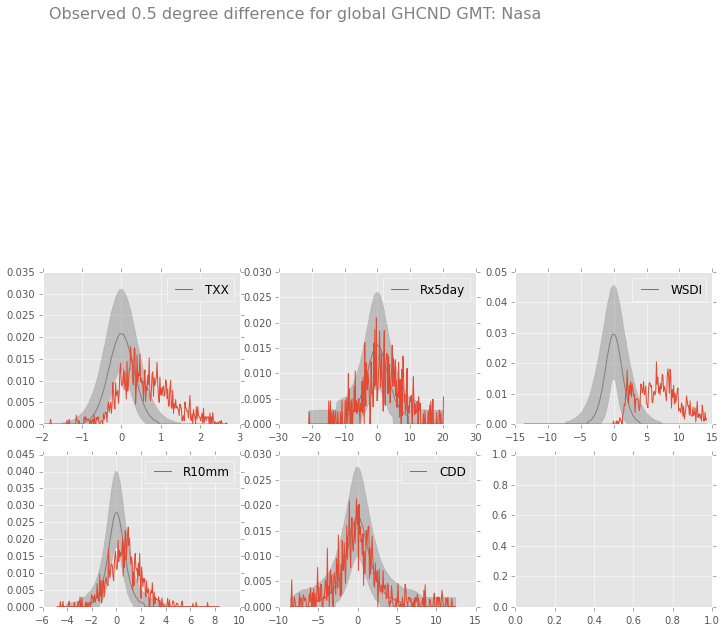

In [85]:
###########
# PLOTS
###########
f,pl=plt.subplots(nrows=2,ncols=3,figsize=(12,6))
pplot=pl.flatten()

region='global'

for varin,k in zip(varinlist,range(len(pplot))):

    pplot[k].plot(varoutdict[varin]._distributions[region]['pdf']['xaxis'],
             varoutdict[varin]._distributions[region]['pdf']['bs_quantiles'][50],color='grey')
    
    pplot[k].fill_between(varoutdict[varin]._distributions[region]['pdf']['xaxis'],
                     varoutdict[varin]._distributions[region]['pdf']['bs_quantiles'][5],
                    varoutdict[varin]._distributions[region]['pdf']['bs_quantiles'][95],color='grey',
                          alpha=0.4),#label='90% ref period')

    pplot[k].plot(varoutdict[varin]._distributions[region]['pdf']['xaxis'],
             varoutdict[varin]._distributions[region]['pdf']['Recent_ref'],label=varin)
                      
    pplot[k].legend(loc='upper right')

# f.suptitle('Observed 0.5 degree difference for GHCND')
pplot[1].text(-100, 0.08,'Observed 0.5 degree difference for '+region+' GHCND GMT: '+gmtds, fontsize=16,color='grey')
plt.savefig('plots/Observed_0p5_degree_difference_for_GHCND_all.pdf')


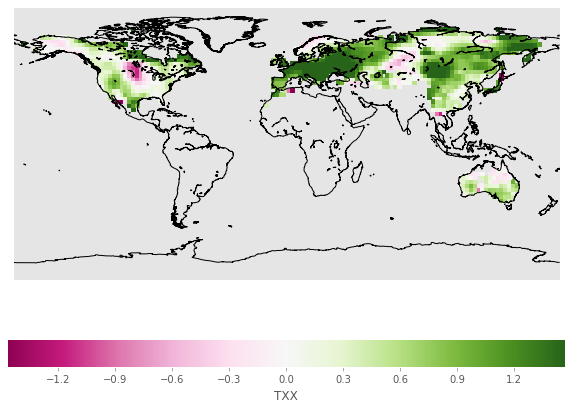

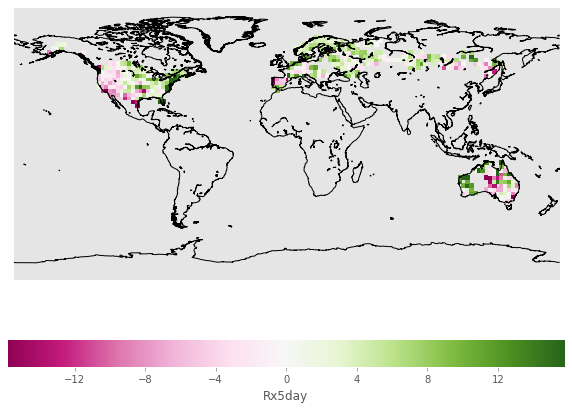

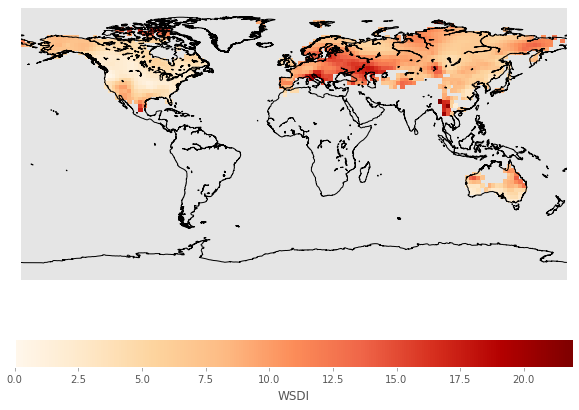

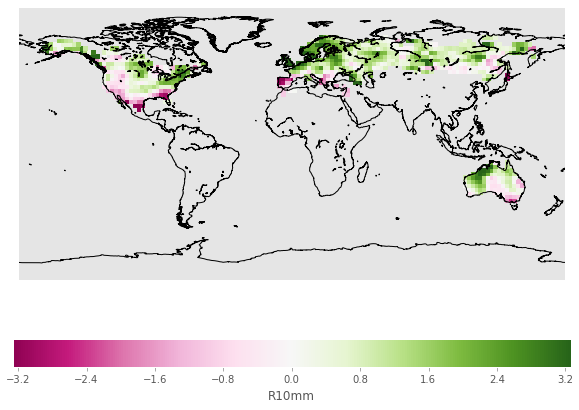

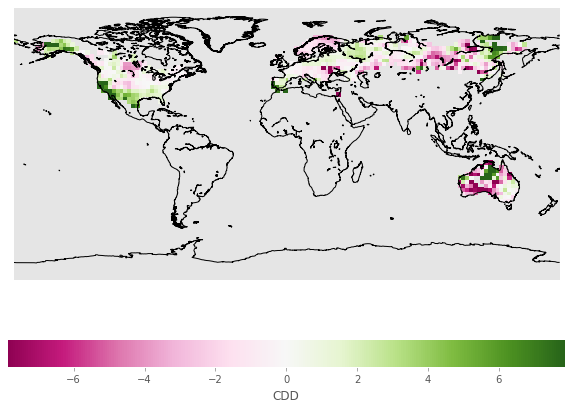

In [87]:
###########
# Show map 
###########
import pdf_processing as pdf; reload(pdf)
for varin in varinlist:
    if varin=='WSDI':
        varoutdict[varin].show_maps('plots/Map_'+varin+'_GHCND.pdf','ref','Recent',centering=False)
    else:
        varoutdict[varin].show_maps('plots/Map_'+varin+'_GHCND.pdf','ref','Recent')